# Posterior overlap

## Bayes factor

$$
\begin{equation}
\begin{split}
\mathcal{B}_U^L &= \frac{ \int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_L) }
{\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)} \\ \nonumber
=& \Bigg[\\
& \bigg< \\
&\;P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,1}|T_1, d_1)\times \\
&\;P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,2}|T_2, d_2) \times \\
&\; P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L) \div \\
& \bigg(P_{pe}(m_{1}, m_{2}, , \chi_{eff}) P_{pe}(\alpha) P_{pe}(\delta) P_{pe}(\iota) P_{pe}(d_{L})\bigg)^2 \div \\
&\; P_{comb}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}|d_1, d_2) \\
&\bigg>_{ m_{1}, m_{2}, d_{L,1}, \iota, \chi_{eff}, d_{L,2}\in P_{comb}(.|d_1, d_2)} \\
& \Bigg] \div \Bigg[\\
& \bigg<\\
&\; P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)\times \\
&\; P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U) \div \\
& \bigg(P_{pe}(m_{1}, m_{2}, \chi_{eff}) P_{pe}(\alpha) P_{pe}(\delta) P_{pe}(\iota) P_{pe}(d_{L})\bigg)^2 \\
&\bigg>_{ m_{1,1}, m_{2,1},\alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}\in P(.|T_1,d_1),}\\&_{\; m_{1,2}, m_{2,2},\alpha_2, \delta_2, \iota_2, \chi_{eff,2}, d_{L,2}\in P(.|T_2,d_2)} \\
& \Bigg]
\end{split}
\end{equation}
$$

**Note**: I didn't seperate out the integrand in the denominator as 
$$\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)=
\int d\theta \frac{P(\theta|d_1)}{P_{pe}(\theta)} P_{astro}(\theta|H_U) 
\int d\theta \frac{P(\theta|d_2)}{P_{pe}(\theta)} P_{astro}(\theta|H_U)$$
This is because I want to use the time delay information in the denominator as well. For unlensed events, time delay follows a possion distribution where its peak depends the on prior range (1 year for this example).

Priors:

* $P_{comb}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}|d_1, d_2)$ is the obtained by combining the posterior distribution of the parameters for the given two dataset.

* $P(m_{1,1}, m_{2,1},\alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|T_1, d_1)$ and $P(m_{1,2}, m_{2,2},\alpha_2, \delta_2, \iota_2, \chi_{eff,2}, d_{L,2}|T_2, d_2)$ are the posterior distribution of the parameters for the given two dataset respectively.

* Multidimensional KDE is used to sample the new parameters for monte carlo integration.

PDFs:

* $P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,1}|T_1, d_1)$, $P(m_{1}, m_{2},\alpha, \delta, \iota, \chi_{eff}, d_{L,2}|T_2, d_2)$ are PDF of the parameters for the given two dataset respectively.

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$ is the PDF of the parameters in the lensed hypothesis.

* $P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)$ and $P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U)$ are the PDF of the parameters in the unlensed hypothesis.

* $P_{pe}(m_{1}, m_{2}, \chi_{eff})$, $P_{pe}(\alpha)$, $P_{pe}(\delta)$, $P_{pe}(\iota)$, $P_{pe}(d_{L})$ are the PDFs obtained from the bilby default BBH's prior distribution.

* Multidimensional KDE is used to find the probability density of the parameters.

In [2]:
import numpy as np
from ler.utils import get_param_from_json, save_json, load_json
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import corner
import matplotlib.lines as mlines
import h5py 
import pandas as pd
import json
import pickle

## Define all scaling functions

In [3]:
import scipy.stats as stats
from scipy.stats import norm

def uniform_to_gaussian(x, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Transform to U(0,1)
    U = x / abs(upper_bound - lower_bound)

    # Transform to standard normal
    Z = norm.ppf(U)

    # If you want a normal distribution with mean mu and standard deviation sigma
    X = mu + sigma * Z
    return X

def gaussian_to_uniform(X, mu=0, sigma=1, upper_bound=0.8, lower_bound=0):
    # Reverse the normal scaling to standard normal
    Z = (X - mu) / sigma

    # Transform standard normal back to U(0,1)
    U = norm.cdf(Z)

    # Scale U(0,1) back to U(0, 0.8)
    x = abs(upper_bound - lower_bound) * U
    return x

def sine_to_gaussian(X):
    uniform = (np.cos(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_sine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    sine = np.arccos(2 * uniform - 1)  # Convert to the sine of the angle
    return sine

def cosine_to_gaussian(X):
    uniform = (np.sin(X) + 1) / 2  # Convert to Uniform[0, 1]
    gaussian = norm.ppf(uniform)  # Apply the inverse CDF of the Gaussian distribution
    return gaussian

def gaussian_to_cosine(X):
    uniform = norm.cdf(X)  # Apply the CDF of the Gaussian distribution
    cosine = np.arcsin(2 * uniform - 1)  # Convert to the cosine of the angle
    return cosine

def scale_to_range(X, min_data=None, max_data=None, min_target=0+0.0001, max_target=np.pi-0.0001):
    if min_data is None:
        min_data = np.min(X)
    if max_data is None:
        max_data = np.max(X)
    X_std = (X - min_data) / (max_data - min_data)
    X_scaled = X_std * (max_target - min_target) + min_target
    return X_scaled

def unscale_to_range(X, min_data, max_data, min_target=0+0.0001, max_target=np.pi-0.0001):
    X_scaled = (X - min_target) / (max_target - min_target)
    X_unscaled = X_scaled * (max_data - min_data) + min_data
    return X_unscaled

# for saving min max values for scaling as json
def save_min_max(data_dict, filename):
    min_max = {}
    for key, value in data_dict.items():
        min_max[key] = dict(
            min_data = np.min(value), 
            max_data = np.max(value),
        )
    save_json(filename, min_max)

In [4]:
def get_model_and_scaler(model_path, scaler_path, min_max_path=None, dir='ler_data'):
    
    with open(dir+'/'+model_path, 'rb') as f:
        dpgmm = pickle.load(f)

    with open(dir+'/'+scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    if min_max_path is not None:
        min_max = load_json(dir+'/'+min_max_path)
        return dpgmm, scaler, min_max
    else:
        return dpgmm, scaler

## Astrophysical parameter distributions

## Lensed events

* $P_{astro}(m_{1}, m_{2}, \alpha, \delta, \iota, \chi_{eff}, d_{L,1}, d_{L,2}, \Delta T_2|H_L)$

In [5]:
# get data for detectable events
lensed_param = get_param_from_json('ler_data/n_lensed_detectable_bbh_po_spin.json')
lensed_param.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'ra', 'dec', 'phase', 'psi', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'mass_1', 'mass_2', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net', 'L1', 'H1', 'V1'])

In [6]:
list_ = ['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'phase', 'psi', 'phi_12', 'phi_jl', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'x0_image_positions', 'x1_image_positions', 'magnifications', 'time_delays', 'image_type', 'n_images', 'L1', 'H1', 'V1']

# delete the unnecessary keys
for key in list_:
    del lensed_param[key]
lensed_param.keys()

dict_keys(['ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'mass_1', 'mass_2', 'effective_luminosity_distance', 'effective_geocent_time', 'optimal_snr_net'])

### For image 1 and 2 only

In [31]:
# seperate out image 1, 2, 3, 4
# this is wrt to time of arrival
lensed_param_1 = {}
lensed_param_2 = {}
lensed_param_3 = {}
lensed_param_4 = {}

for key, value in lensed_param.items():
    if np.shape(np.shape(value))[0]==2:
        lensed_param_1[key] = value[:,0]
        lensed_param_2[key] = value[:,1]
        lensed_param_3[key] = value[:,2]
        lensed_param_4[key] = value[:,3]
    else:
        lensed_param_1[key] = value
        lensed_param_2[key] = value
        lensed_param_3[key] = value
        lensed_param_4[key] = value

# For image 1 and 2 only
# only keep snr > 8
idx_snr1 = lensed_param_1['optimal_snr_net'] > 8
idx_snr2 = lensed_param_2['optimal_snr_net'] > 8
idx_snr = idx_snr1 & idx_snr2

new_dict = dict(
    m1 = lensed_param_1['mass_1'][idx_snr],
    m2 = lensed_param_1['mass_2'][idx_snr],
    costheta_jn = np.cos(lensed_param_1['theta_jn'][idx_snr]),
    a_1 = lensed_param_1['a_1'][idx_snr],
    a_2 = lensed_param_1['a_1'][idx_snr],
    tilt_1 = lensed_param_1['tilt_1'][idx_snr],
    tilt_2 = lensed_param_1['tilt_2'][idx_snr],
    dl_1 = lensed_param_1['effective_luminosity_distance'][idx_snr],
    dl_2 = lensed_param_2['effective_luminosity_distance'][idx_snr],
    dt_12 = lensed_param_2['effective_geocent_time'][idx_snr] - lensed_param_1['effective_geocent_time'][idx_snr],
    ra = lensed_param_1['ra'][idx_snr],
    sindec = np.cos(np.pi/2. - lensed_param_1['dec'][idx_snr]),
)

# with effective spin
chi_eff = (new_dict['a_1']*np.cos(new_dict['tilt_1']) + new_dict['a_2']*np.cos(new_dict['tilt_2']))/(new_dict['m1'] + new_dict['m2'])

In [32]:
data = np.array([new_dict['m1'], new_dict['m2'], new_dict['ra'], new_dict['sindec'], new_dict['costheta_jn'], chi_eff, new_dict['dl_1'], new_dict['dl_2'], new_dict['dt_12']]).T
np.shape(data)

data_dict = dict(
    mass_1 = data[:,0],
    mass_2 = data[:,1],
    ra = data[:,2],
    sindec = data[:,3],
    costheta_jn = data[:,4],
    chi_eff = data[:,5],
    dl_1 = data[:,6],
    dl_2 = data[:,7],
    dt_12 = data[:,8]
)

In [33]:
save_min_max(data_dict, 'ler_data/min_max_astro_lensed.json')

### Scaling

* to make all distribution to have the same scale

* to make all distribution to have Gaussian like shape

* to avoid sharp cuts in the distribution

* all scaling functions are invertible

In [44]:
train_data_ = data.copy()
# m1_min = min_max_dict['mass_1']['min_data']
# m1_max = min_max_dict['mass_1']['max_data']
# m2_min = min_max_dict['mass_2']['min_data']
# m2_max = min_max_dict['mass_2']['max_data']

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl_1 and Dl_2
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)
train_data_[:,7] = np.log10(train_data_[:,7]) # convert to log10(Mpc)

# scale dt_12
train_data_[:,8] = np.log10(train_data_[:,8]/(24*3600)) # convert to log10(days)

In [45]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)
# scaled_data = train_data_

# Fit the model
# time for training: 7m 57.2s
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [36]:
# find pdf values of some random points
size = 10
min_max_dict = load_json('ler_data/min_max_astro_lensed.json')
mass_1 = np.linspace(min_max_dict['mass_1']['min_data'], min_max_dict['mass_1']['max_data'], size)
mass_2 = np.linspace(min_max_dict['mass_2']['min_data'], min_max_dict['mass_2']['max_data'], size)
ra = np.linspace(min_max_dict['ra']['min_data'], min_max_dict['ra']['max_data'], size)
# dec = np.linspace(min_max_dict['dec']['min_data'], min_max_dict['dec']['max_data'], size)
sindec = np.linspace(min_max_dict['sindec']['min_data'], min_max_dict['sindec']['max_data'], size)
# theta_jn = np.linspace(min_max_dict['theta_jn']['min_data'], min_max_dict['theta_jn']['max_data'], size)
cos_theta_jn = np.linspace(min_max_dict['costheta_jn']['min_data'], min_max_dict['costheta_jn']['max_data'], size)
chi_eff = np.linspace(min_max_dict['chi_eff']['min_data'], min_max_dict['chi_eff']['max_data'], size)
dl_1 = np.linspace(min_max_dict['dl_1']['min_data'], min_max_dict['dl_1']['max_data'], size)
dl_2 = np.linspace(min_max_dict['dl_2']['min_data'], min_max_dict['dl_2']['max_data'], size)
dt_12 = np.linspace(min_max_dict['dt_12']['min_data'], min_max_dict['dt_12']['max_data'], size)

# scale
# mass_1 = scale_to_range(mass_1, min_data=m1_min, max_data=m1_max)
# mass_1 = sine_to_gaussian(mass_1)
# mass_2 = scale_to_range(mass_2, min_data=m2_min, max_data=m2_max)
# mass_2 = sine_to_gaussian(mass_2)
# ra = uniform_to_gaussian(ra, mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# dec = cosine_to_gaussian(dec)
# theta_jn = sine_to_gaussian(theta_jn)
dl_1 = np.log10(dl_1)
dl_2 = np.log10(dl_2)
dt_12 = np.log10(dt_12/(24*3600))

# feature scaling
X = np.array([mass_1, mass_2, ra, dec, theta_jn, chi_eff, dl_1, dl_2, dt_12]).T

# scale
scaled_X = scaler.transform(X)

# pdf values
pdf_values = KDE(scaled_X.T)

In [37]:
pdf_values

array([0.00000000e+000, 4.90150421e-108, 1.45710142e-096, 2.12194256e-100,
       2.47854422e-040, 1.27312310e-030, 2.45089989e-136, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000])

In [100]:
pdf_values

array([4.47020386e-41, 1.56324876e-10, 7.69630736e-10, 3.42813401e-10,
       1.20528785e-09, 7.96517326e-08, 1.11427960e-09, 6.51911736e-16,
       2.25886730e-22, 6.23900942e-76])

In [46]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])
# unscale Dl_1 and Dl_2
new_samples[:,6] = 10**new_samples[:,6]
new_samples[:,7] = 10**new_samples[:,7]
# unscale dt_12
new_samples[:,8] = 10**(new_samples[:,8])*(24*3600)

print(np.shape(new_samples))
print(np.shape(data))

(40000, 9)
(40034, 9)


### Plotting

* to show sampled points from generated KDE is same as the original distribution

* to show that correlation is preserved 

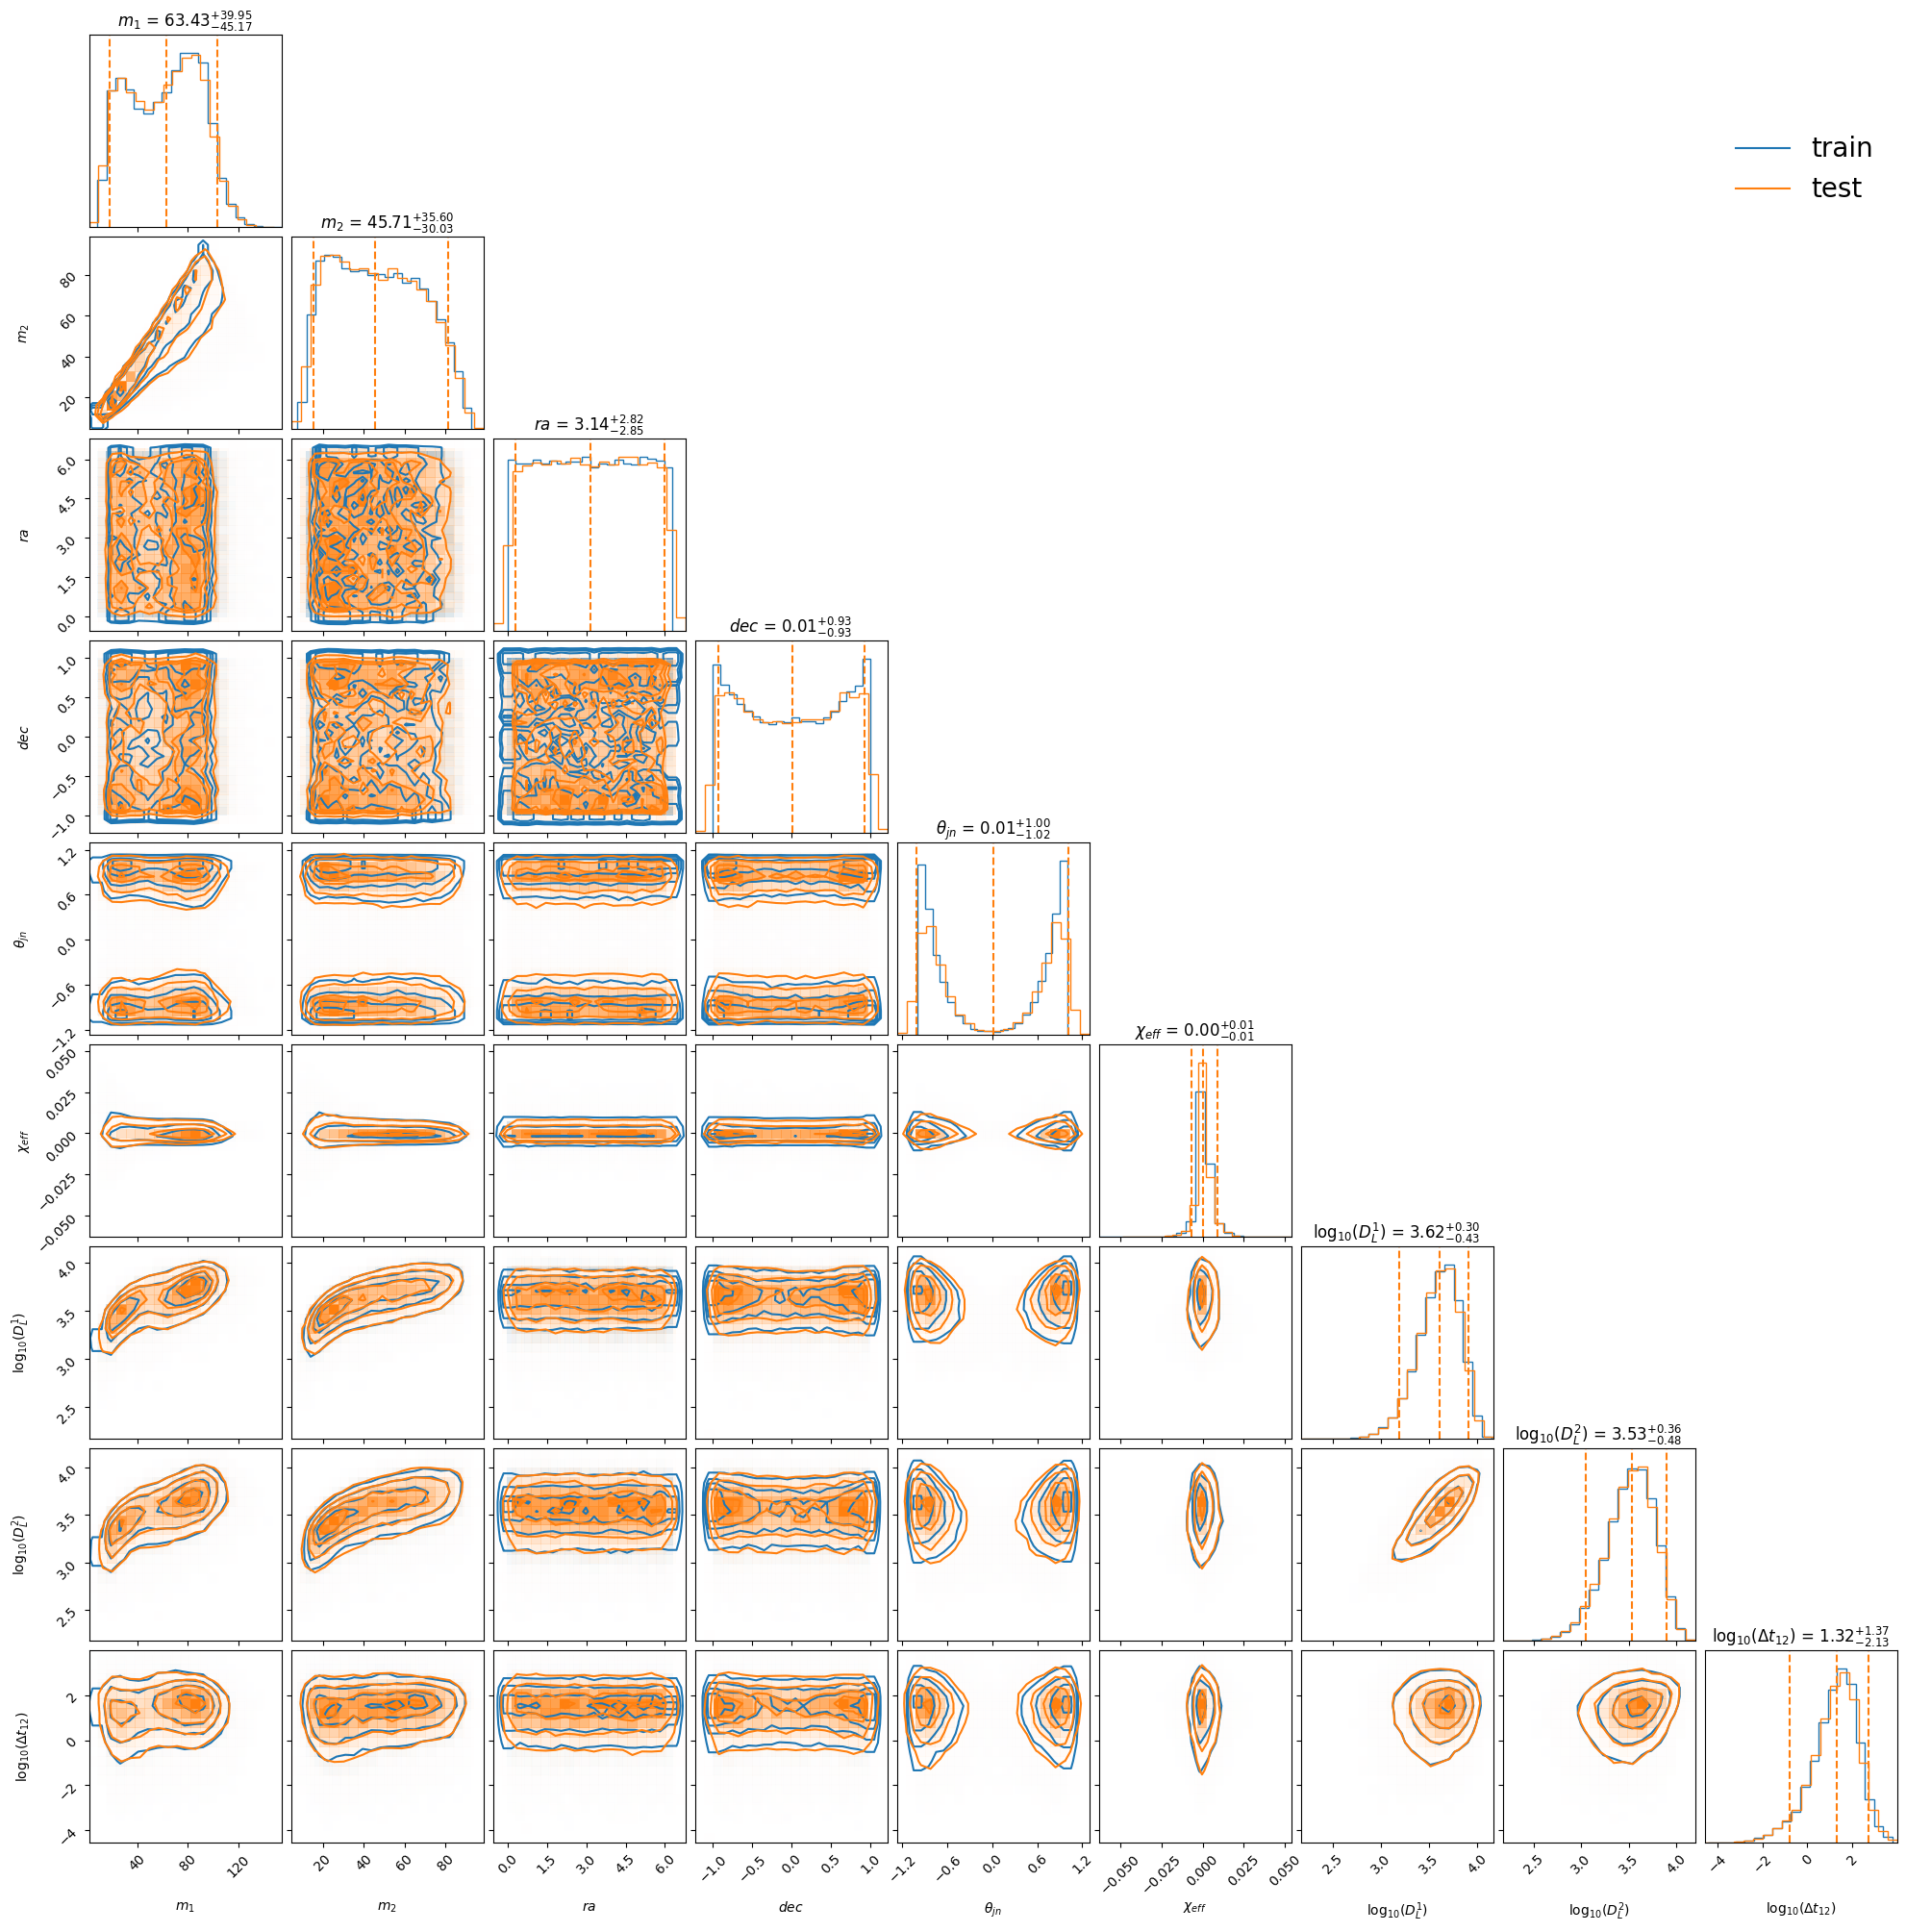

In [47]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_L^1)$",
    r"log$_{10}(D_L^2)$",
    r"log$_{10}(\Delta t_{12})$",
]

# to see well, convert to log scale for some parameters
data_plot = data.copy()
data_plot[:,6] = np.log10(data_plot[:,6])
data_plot[:,7] = np.log10(data_plot[:,7])
data_plot[:,8] = np.log10(data_plot[:,8]/(24*3600))
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])
new_samples_plot[:,7] = np.log10(new_samples_plot[:,7])
new_samples_plot[:,8] = np.log10(new_samples_plot[:,8]/(24*3600))

fig = corner.corner(data_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 9), loc="upper right"
)
plt.gcf()
plt.show()

* the KDE is good enough to capture the distribution of the data

In [50]:
KDE

In [51]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_astro_lensed.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_astro_lensed.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_lensed.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_lensed.pkl', 'rb') as f:
#     scaler = pickle.load(f)

## Unlensed events

* $P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)$

* $P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U)$

In [52]:
# get data for detectable events
unlensed_param = get_param_from_json('ler_data/n_unlensed_detectable_bbh_po_spin.json')
unlensed_param.keys()

list_ = ['zs', 'phase', 'psi', 'phi_12', 'phi_jl', 'mass_1_source', 'mass_2_source', 'L1', 'H1', 'V1', 'optimal_snr_net']

# delete the unnecessary keys
for key in list_:
    del unlensed_param[key]
print(unlensed_param.keys())
print(np.shape(unlensed_param['mass_1']))

dict_keys(['geocent_time', 'ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'luminosity_distance', 'mass_1', 'mass_2'])
(50000,)


In [53]:
# note that geocent_time is not 
# plt.hist(unlensed_param['geocent_time'], bins=100, alpha=0.5, histtype='step', color='C0', label='unlensed', density=True)
# plt.show()

In [54]:
# we will create two sets of unlensed parameters
size = 25000
idx = np.random.choice(np.arange(0,2*size), 2*size, replace=False)
idx1 = idx[:size]
idx2 = idx[size:]

# let's make sure that 2nd set comes after the first set in time
geocent_time1 = unlensed_param['geocent_time'][idx1]
geocent_time2 = unlensed_param['geocent_time'][idx2]
mask = geocent_time2 < geocent_time1
# swap the values
# geocent_time1[mask], geocent_time2[mask] = geocent_time2[mask], geocent_time1[mask]
new_dict1 = dict()
new_dict2 = dict()
for key, value in unlensed_param.items():
    new_dict1[key] = value[idx1]
    new_dict2[key] = value[idx2]
    # swap the values
    new_dict1[key][mask], new_dict2[key][mask] = new_dict2[key][mask], new_dict1[key][mask]
new_dict1.keys()

dict_keys(['geocent_time', 'ra', 'dec', 'theta_jn', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'luminosity_distance', 'mass_1', 'mass_2'])

In [55]:
dt12 = new_dict2['geocent_time'] - new_dict1['geocent_time']
chi_eff1 = (new_dict1['a_1']*np.cos(new_dict1['tilt_1']) + new_dict1['a_2']*np.cos(new_dict1['tilt_2']))/(new_dict1['mass_1'] + new_dict1['mass_2'])
chi_eff2 = (new_dict2['a_1']*np.cos(new_dict2['tilt_1']) + new_dict2['a_2']*np.cos(new_dict2['tilt_2']))/(new_dict2['mass_1'] + new_dict2['mass_2'])

In [56]:
data1 = np.array([new_dict1['mass_1'], new_dict1['mass_2'], new_dict1['ra'], new_dict1['dec'], new_dict1['theta_jn'], chi_eff1, new_dict1['luminosity_distance']]).T
data2 = np.array([new_dict2['mass_1'], new_dict2['mass_2'], new_dict2['ra'], new_dict2['dec'], new_dict2['theta_jn'], chi_eff2, new_dict2['luminosity_distance'], dt12]).T
print(min(data1[:,0]), max(data1[:,0]))
print(min(data1[:,1]), max(data1[:,1]))
print(min(data2[:,0]), max(data2[:,0]))
print(min(data2[:,1]), max(data2[:,1]))

6.137660581451614 152.80172256600665
5.904778750805487 92.16253781674986
6.515876470439876 139.84992094240013
6.254406992554522 92.11162927696776


In [59]:
# save min max values for scaling
data_dict1 = dict(
    mass_1 = data1[:,0],
    mass_2 = data1[:,1],
    ra = data1[:,2],
    sindec = np.cos(np.pi/2. - data1[:,3]),
    costheta_jn = np.cos(data1[:,4]),
    chi_eff = data1[:,5],
    dl = data1[:,6],
)

save_min_max(data_dict1, 'ler_data/min_max_astro_unlensed1.json')

# data 2
data_dict2 = dict(
    mass_1 = data2[:,0],
    mass_2 = data2[:,1],
    ra = data2[:,2],
    sindec = np.cos(np.pi/2. - data2[:,3]),
    costheta_jn = np.cos(data2[:,4]),
    chi_eff = data2[:,5],
    dl = data2[:,6],
    dt_12 = data2[:,7]
)

save_min_max(data_dict2, 'ler_data/min_max_astro_unlensed2.json')

In [19]:
# labels = [
#     r"$m_1$",
#     r"$m_2$",
#     r"$ra$",
#     r"$dec$",
#     r"$\theta_{jn}$",
#     r"$\chi_{eff}$",
#     r"log$_{10}(D_L)$",
# ]
# fig = corner.corner(data1,color='C1', labels=labels)

# plt.show()

### Dataset 1 : Unlensed

* $P_{astro}(m_{1,1}, m_{2,1}, \alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|H_U)$

In [60]:
data1 = np.array([data_dict1['mass_1'], data_dict1['mass_2'], data_dict1['ra'], data_dict1['sindec'], data_dict1['costheta_jn'], data_dict1['chi_eff'], data_dict1['dl']]).T
train_data_ = data1.copy()
# m1_min = np.min(train_data_[:,0])
# m1_max = np.max(train_data_[:,0])
# m2_min = np.min(train_data_[:,1])
# m2_max = np.max(train_data_[:,1])

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)

In [62]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
# time for training: 2m 53.1s
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [117]:
# # load model
# dpgmm = get_model_and_scaler('gaussian_kdeastro_unlensed1.pkl', 'scaler_astro_unlensed1.pkl')[0]

In [65]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])
# unscale Dl
new_samples[:,6] = 10**new_samples[:,6]

print(np.shape(new_samples))
print(np.shape(data1))

(40000, 7)
(25000, 7)


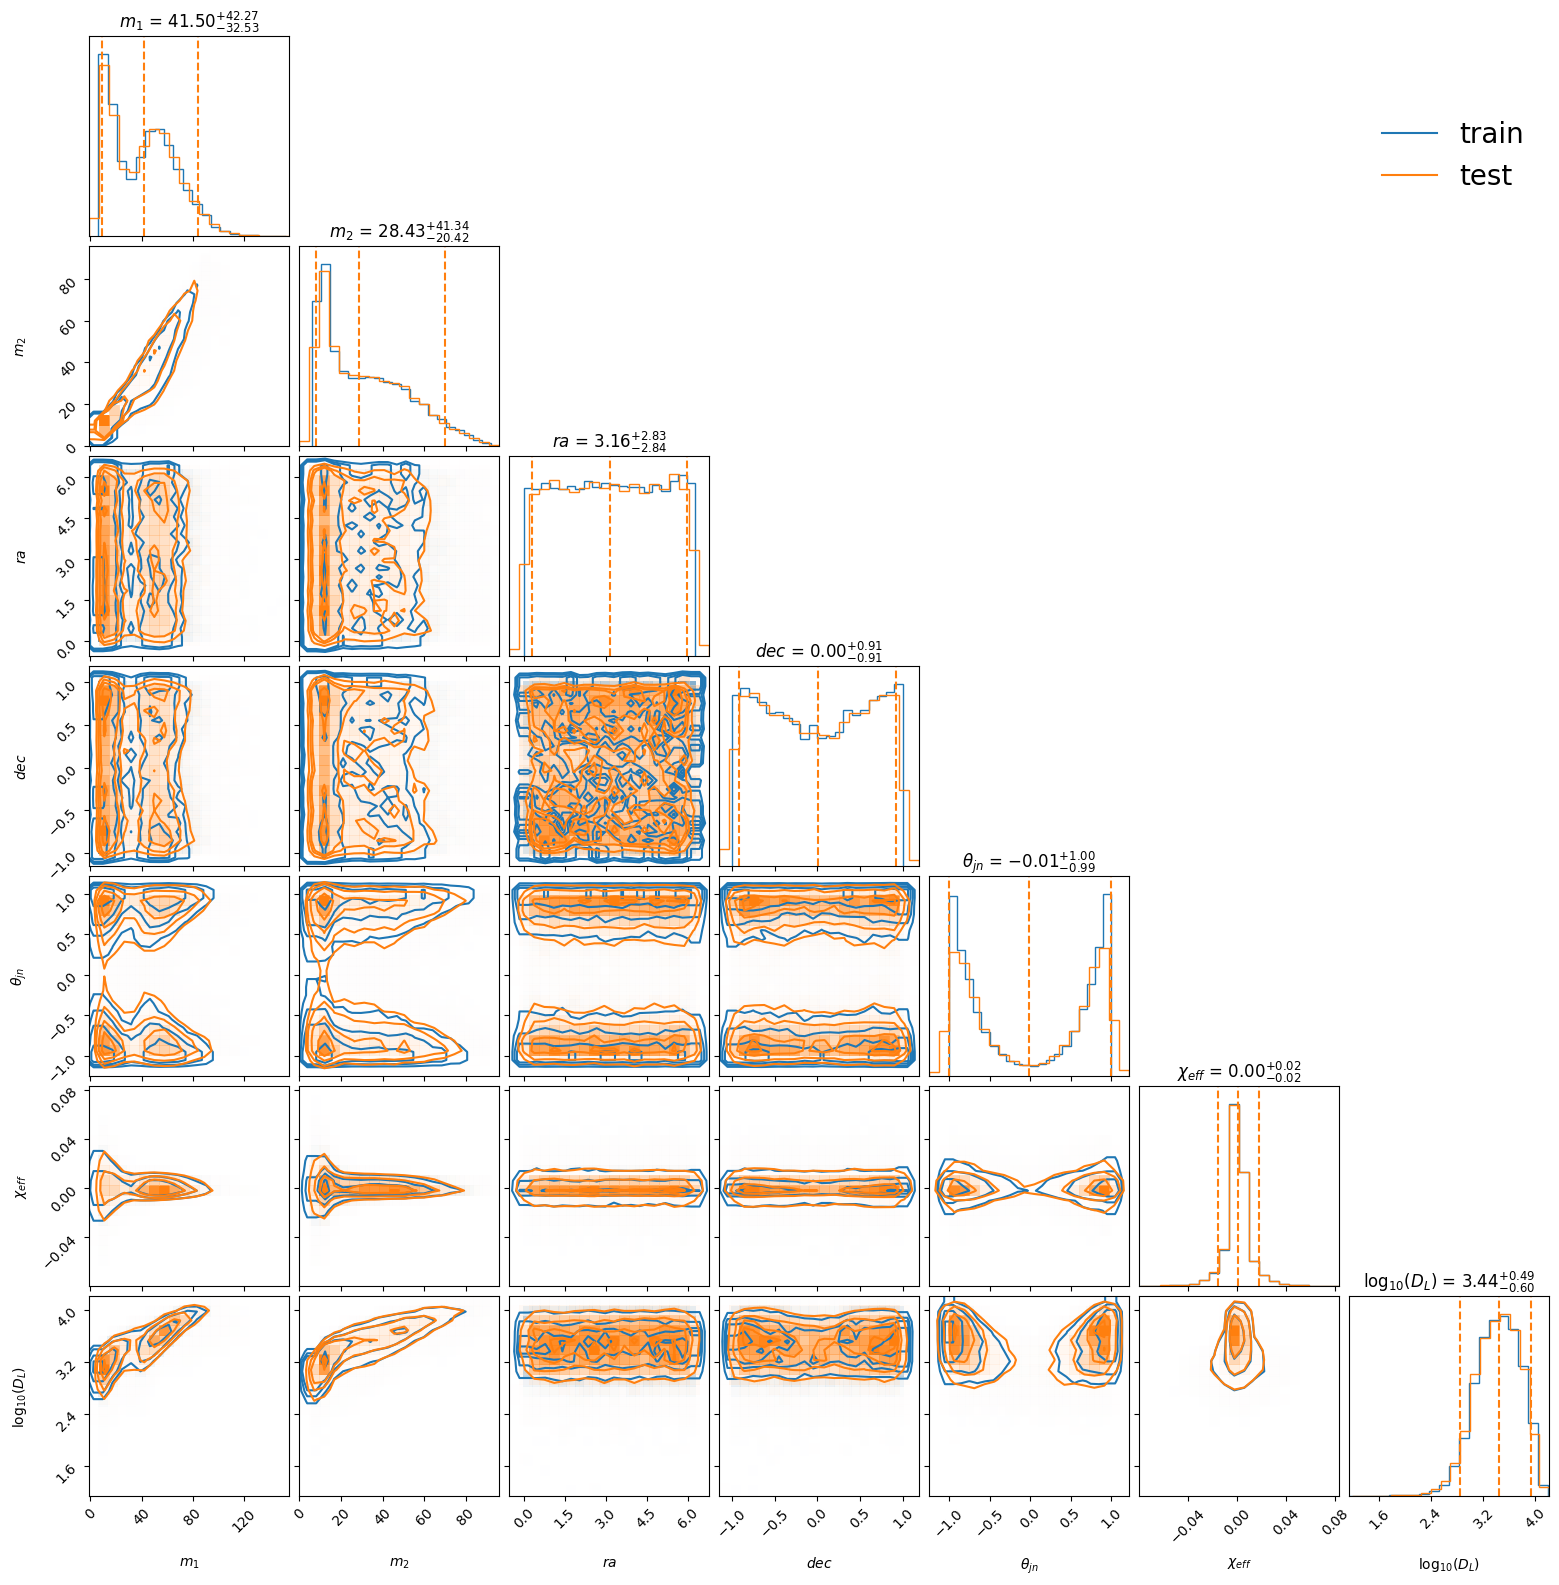

In [66]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_L)$",
]

# to see well, convert to log scale for some parameters
data1_plot = data1.copy()
data1_plot[:,6] = np.log10(data1_plot[:,6])
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])

fig = corner.corner(data1_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 7), loc="upper right"
)
plt.gcf()
plt.show()

In [67]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_astro_unlensed1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)

### Dataset 2: Unlensed

* $P_{astro}(m_{1,2}, m_{2,2}, d_{L,2}, \iota_2, \chi_{eff,2}, d_{L,2}, \Delta T_2|H_U)$

* no need to save min max values for scaling

In [68]:
data2 = np.array([data_dict2['mass_1'], data_dict2['mass_2'], data_dict2['ra'], data_dict2['sindec'], data_dict2['costheta_jn'], data_dict2['chi_eff'], data_dict2['dl'], data_dict2['dt_12']]).T
train_data_ = data2.copy()
# m1_min = np.min(train_data_[:,0])
# m1_max = np.max(train_data_[:,0])
# m2_min = np.min(train_data_[:,1])
# m2_max = np.max(train_data_[:,1])

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)

# scale dt_12
train_data_[:,7] = np.log10(train_data_[:,7]/(24*3600)) # convert to log10(days)
# train_data_[:,7] = scale_to_range(train_data_[:,7], min_data=-2.2, max_data=2.6)
# train_data_[:,7] = sine_to_gaussian(train_data_[:,7])

In [69]:
# plt.figure(figsize=(4,4))
# plt.hist(train_data_[:,7], bins=30, alpha=0.5, histtype='step', color='C0', label='unlensed', density=True)
# plt.show()

In [70]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
# time for training: 2m 53.1s
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

# # load model
# dpgmm,scaler = get_model_and_scaler('gaussian_kdeastro_unlensed2.pkl', 'scaler_astro_unlensed2.pkl')

In [71]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])

# unscale Dl
new_samples[:,6] = 10**new_samples[:,6]
# unscale dt_12
# new_samples[:,7] = gaussian_to_sine(new_samples[:,7])
# new_samples[:,7] = unscale_to_range(new_samples[:,7], min_data=-2.2, max_data=2.6)
new_samples[:,7] = 10**(new_samples[:,7])*(24*3600)

print(np.shape(new_samples))
print(np.shape(data2))

(40000, 8)
(25000, 8)


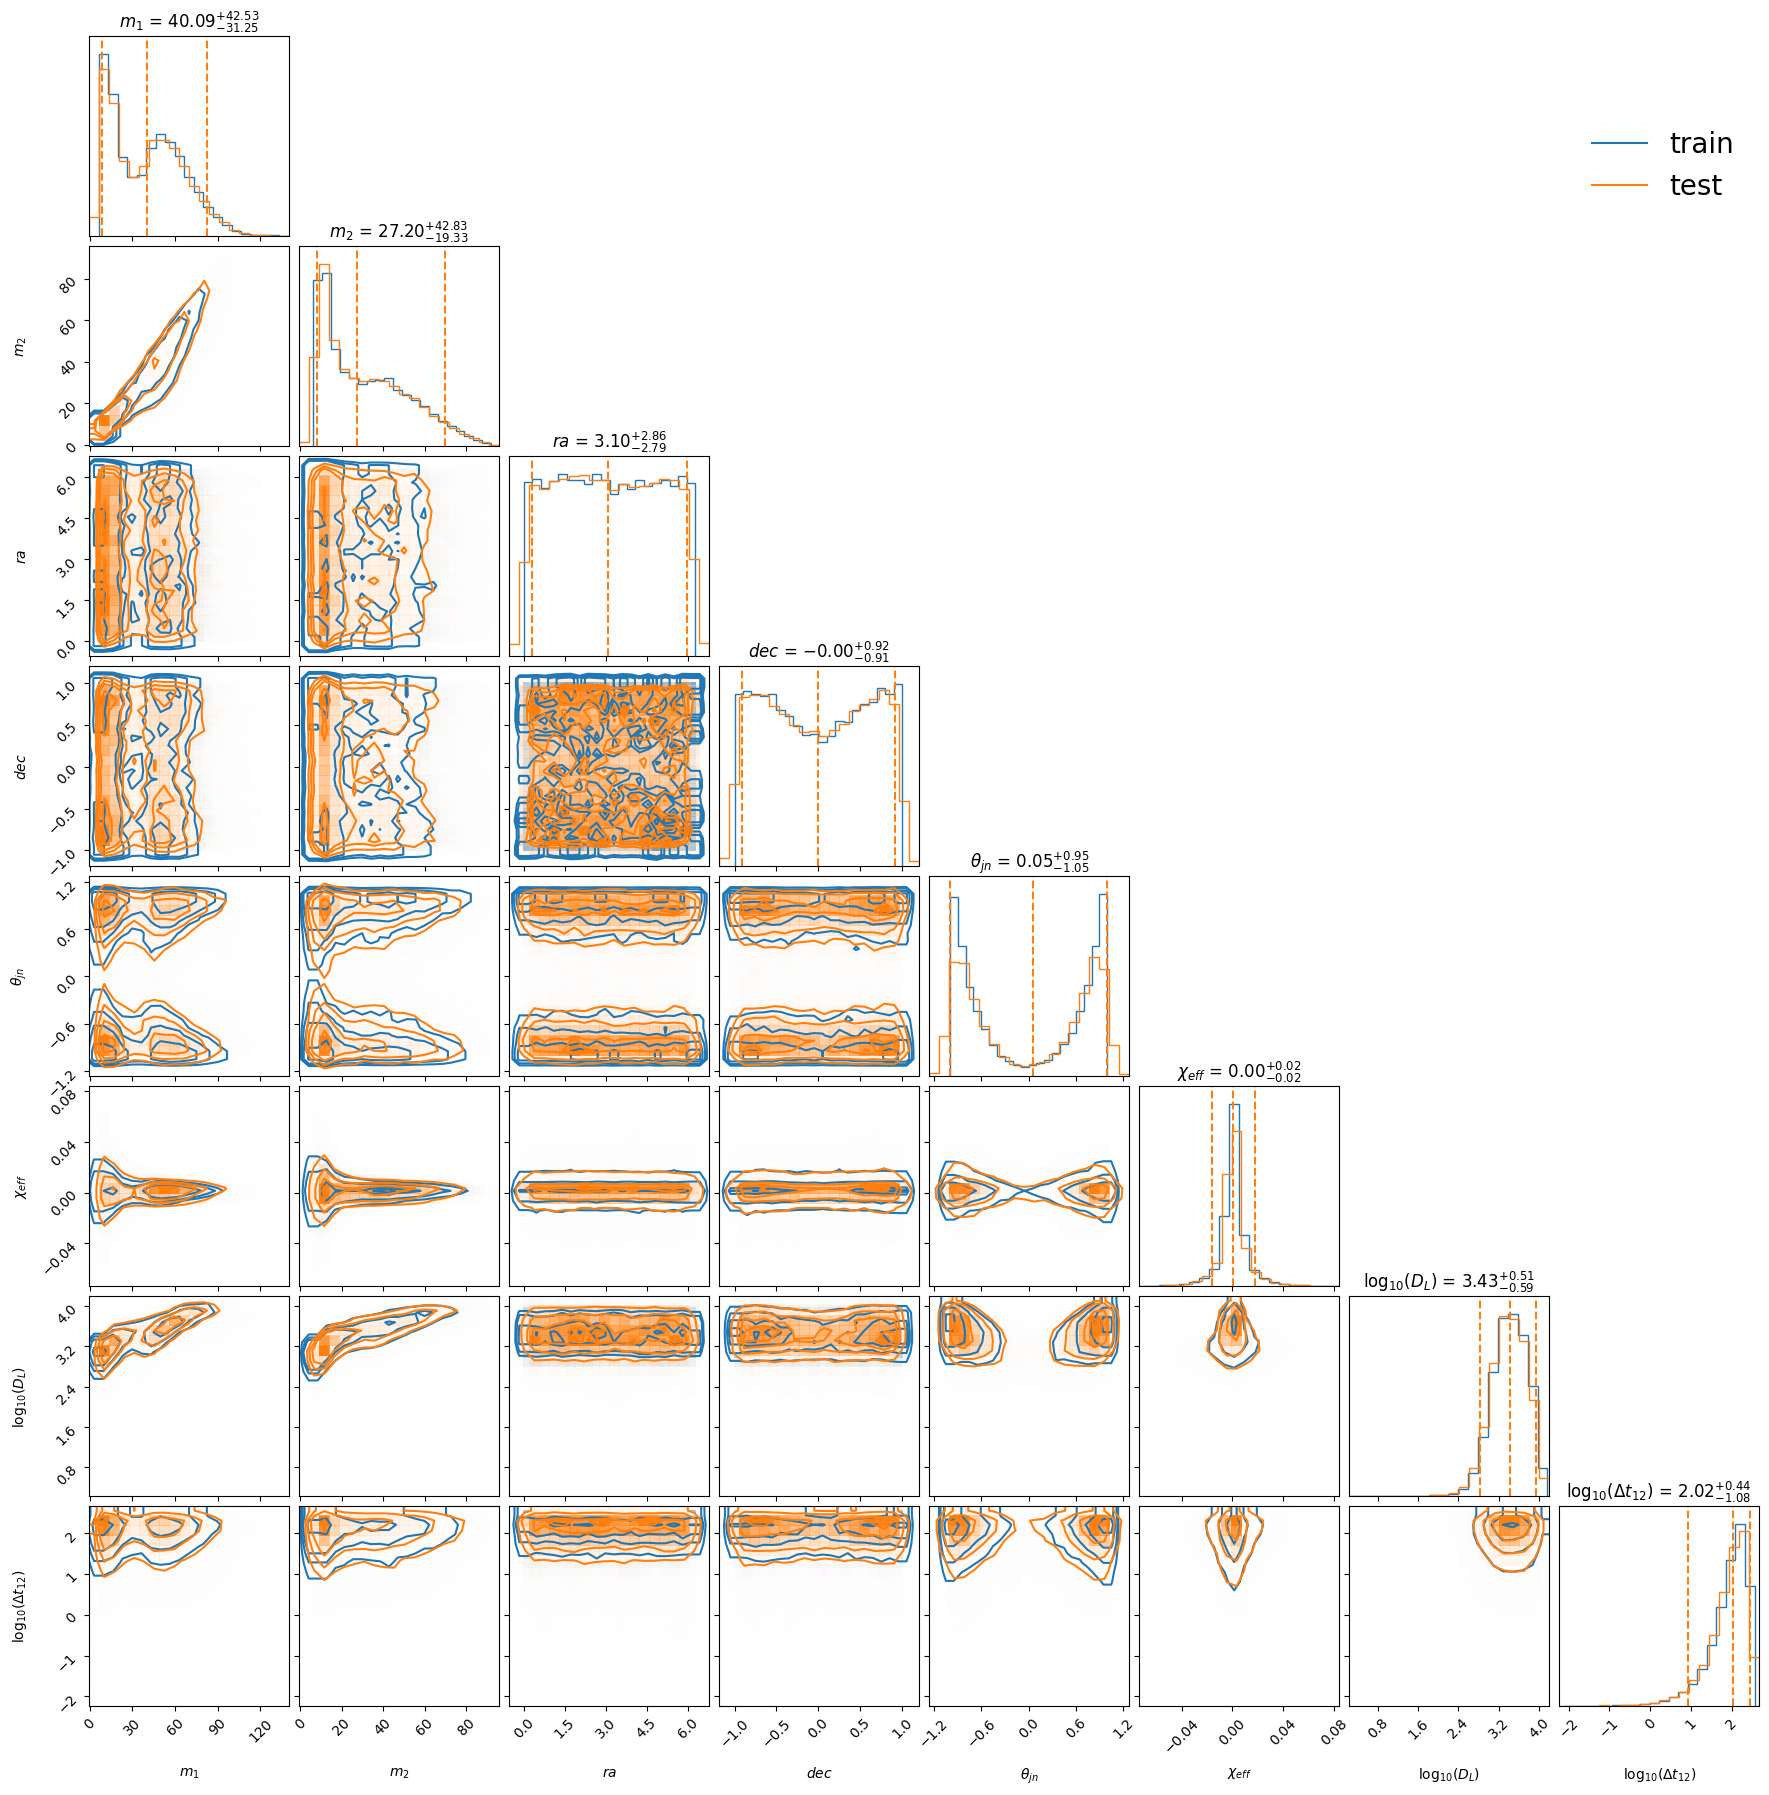

In [72]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_L)$",
    r"log$_{10}(\Delta t_{12})$",
]

# to see well, convert to log scale for some parameters
data2_plot = data2.copy()
data2_plot[:,6] = np.log10(data2_plot[:,6])
data2_plot[:,7] = np.log10(data2_plot[:,7]/(24*3600))
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])
new_samples_plot[:,7] = np.log10(new_samples_plot[:,7]/(24*3600))

fig = corner.corner(data2_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 8), loc="upper right"
)
plt.gcf()
plt.show()

In [73]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_astro_unlensed2.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_astro_unlensed2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)

## Posterior distribution

In [75]:
l1_ps_1=pd.read_csv('../data/test_data/2_5816_896868863.052364587-1.dat',delimiter='\t')
l1_ps_2=pd.read_csv('../data/test_data/2_5816_896868759.838516950-2.dat',delimiter='\t')

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode


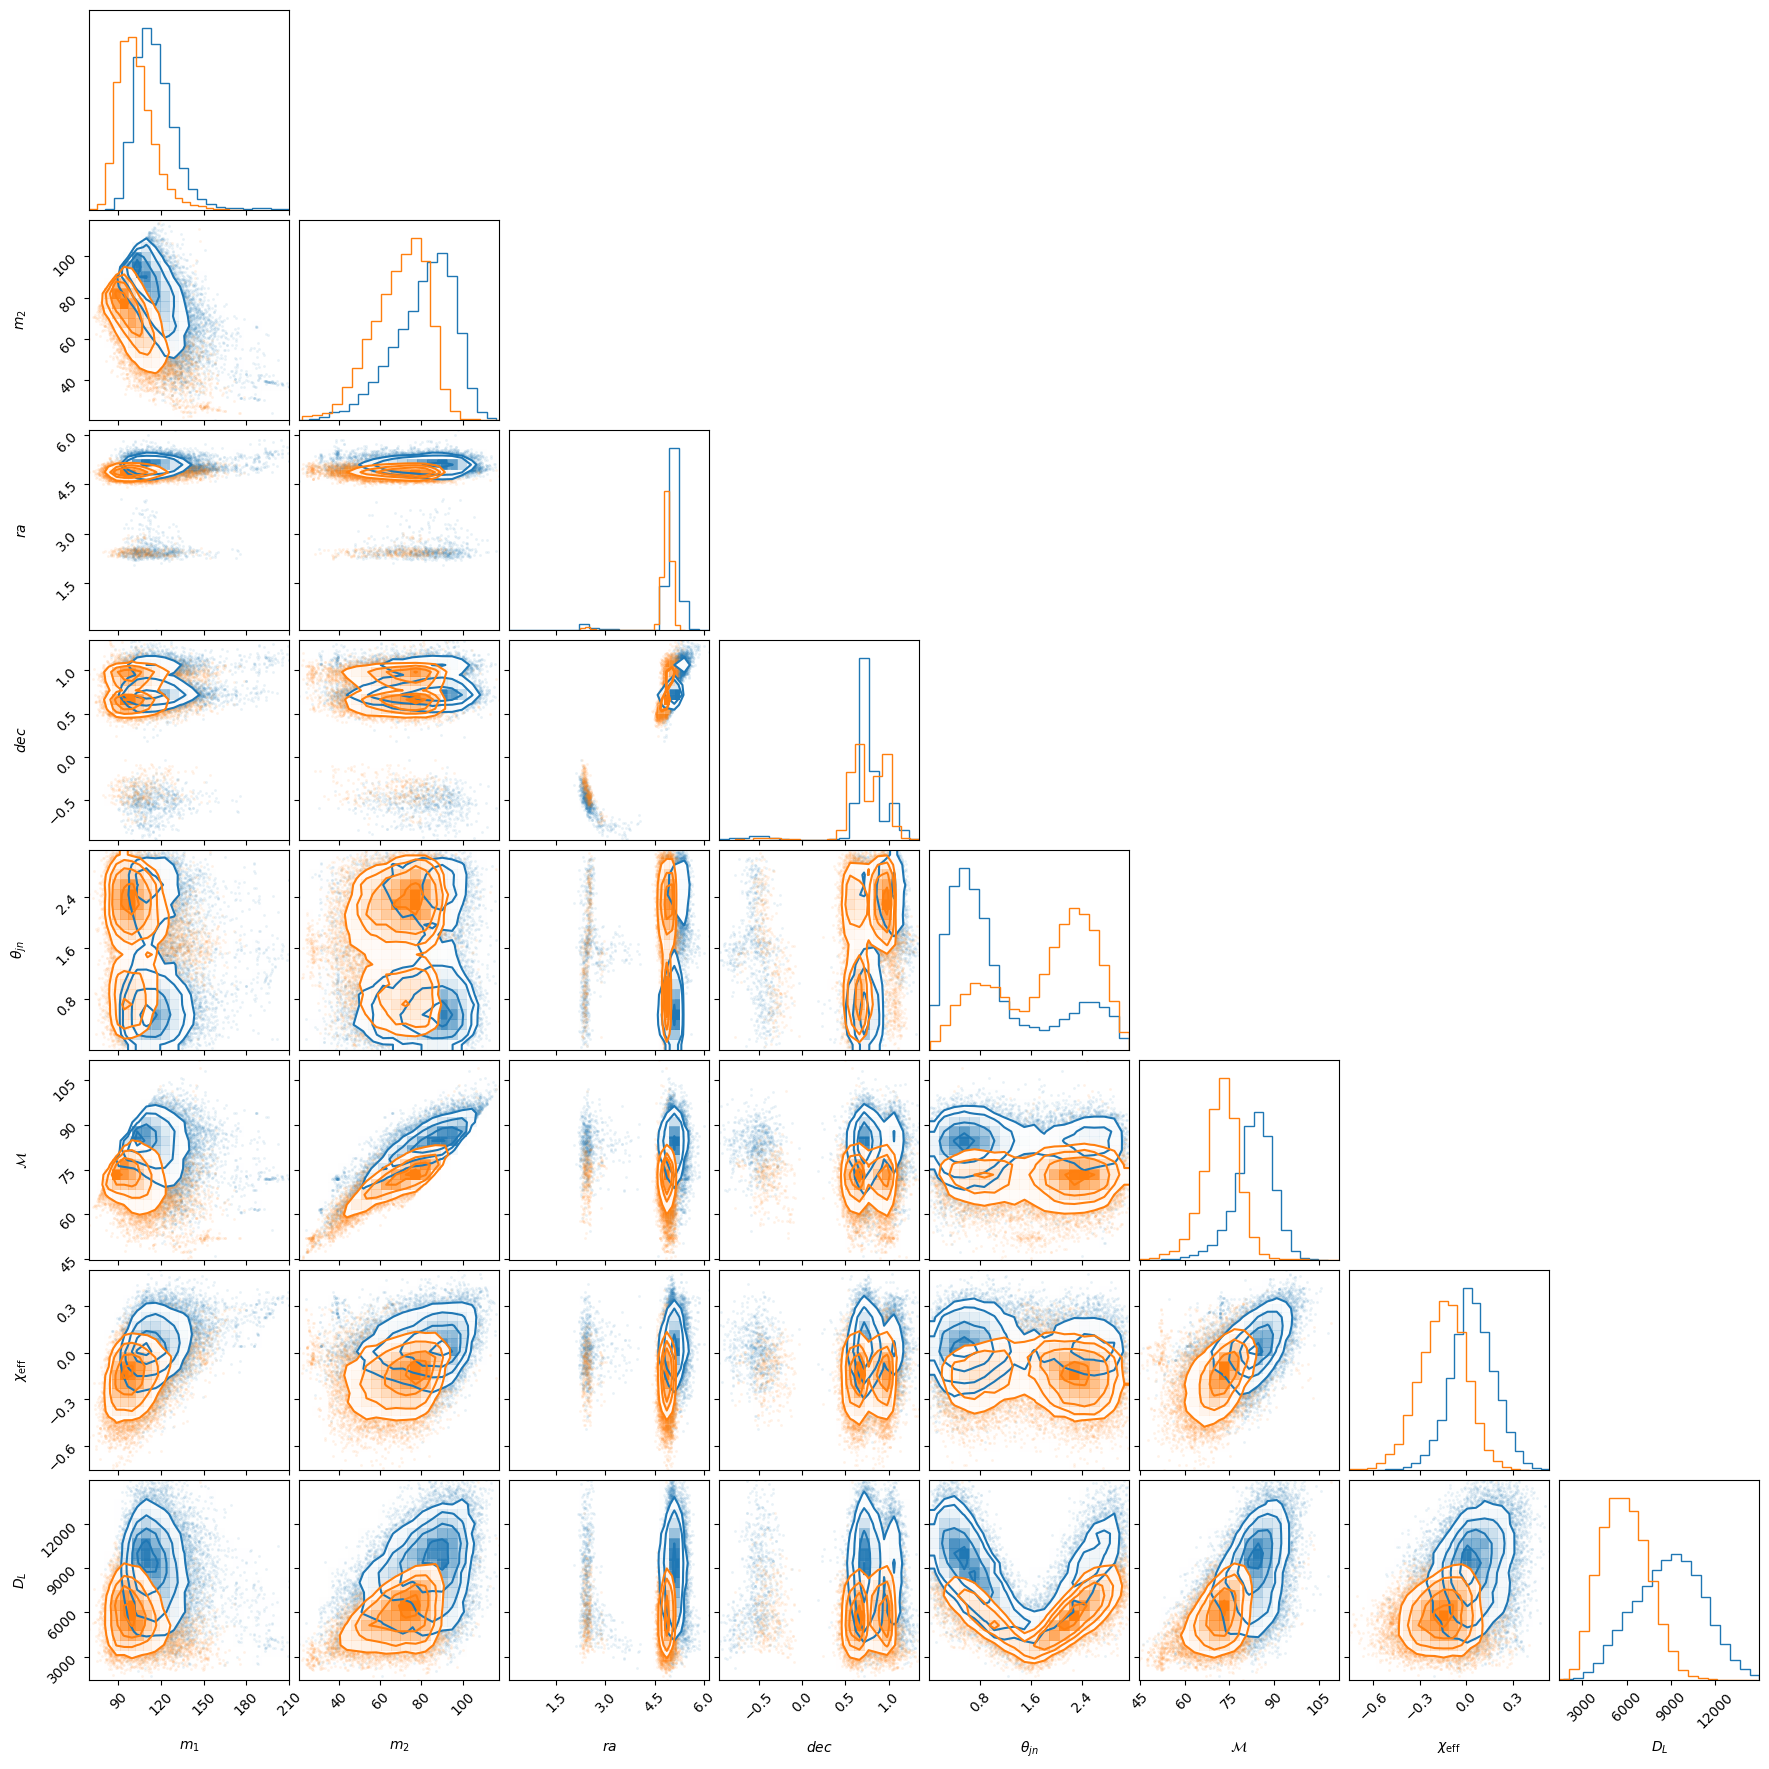

In [31]:
params = [
    "m1",
    "m2",
    "ra",
    "dec",
    "theta_jn","mc","chi_eff","distance"]
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\mathcal{M}$",
    r"$\chi_{\rm eff}$",
    r"$D_L$"
]
fig = corner.corner(l1_ps_1[params],color = 'C0')
corner.corner(l1_ps_2[params],fig=fig,color='C1', labels=labels)

plt.show()

### Dataset 1

* $P(m_{1,1}, m_{2,1},\alpha_1, \delta_1, \iota_1, \chi_{eff,1}, d_{L,1}|T_1,d_1)$ or $P(.|T_1,d_1)$

In [76]:
data1 = np.array([l1_ps_1['m1'], l1_ps_1['m2'], l1_ps_1['ra'], l1_ps_1['dec'], l1_ps_1['theta_jn'], l1_ps_1['chi_eff'], l1_ps_1['distance']]).T

In [77]:
data_dict = dict(
    mass_1 = data1[:,0],
    mass_2 = data1[:,1],
    ra = data1[:,2],
    sindec = np.cos(np.pi/2. - data1[:,3]),
    costheta_jn = np.cos(data1[:,4]),
    chi_eff = data1[:,5],
    dl = data1[:,6],
)

save_min_max(data_dict, 'ler_data/min_max_posterior_data1.json')

In [78]:
data1 = np.array([data_dict['mass_1'], data_dict['mass_2'], data_dict['ra'], data_dict['sindec'], data_dict['costheta_jn'], data_dict['chi_eff'], data_dict['dl']]).T
train_data_ = data1.copy()
# m1_min = np.min(train_data_[:,0])
# m1_max = np.max(train_data_[:,0])
# m2_min = np.min(train_data_[:,1])
# m2_max = np.max(train_data_[:,1])

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)

# scale dt_12
# train_data_[:,7] = np.log10(train_data_[:,7]/(24*3600)) # convert to log10(days)
# train_data_[:,7] = scale_to_range(train_data_[:,7], min_data=-2.2, max_data=2.6)
# train_data_[:,7] = sine_to_gaussian(train_data_[:,7])

In [79]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [80]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])

# unscale Dl
new_samples[:,6] = 10**new_samples[:,6]
# unscale dt_12
# new_samples[:,7] = gaussian_to_sine(new_samples[:,7])
# new_samples[:,7] = unscale_to_range(new_samples[:,7], min_data=-2.2, max_data=2.6)
# new_samples[:,7] = 10**(new_samples[:,7])*(24*3600)

print(np.shape(new_samples))
print(np.shape(data1))

(40000, 7)
(20197, 7)


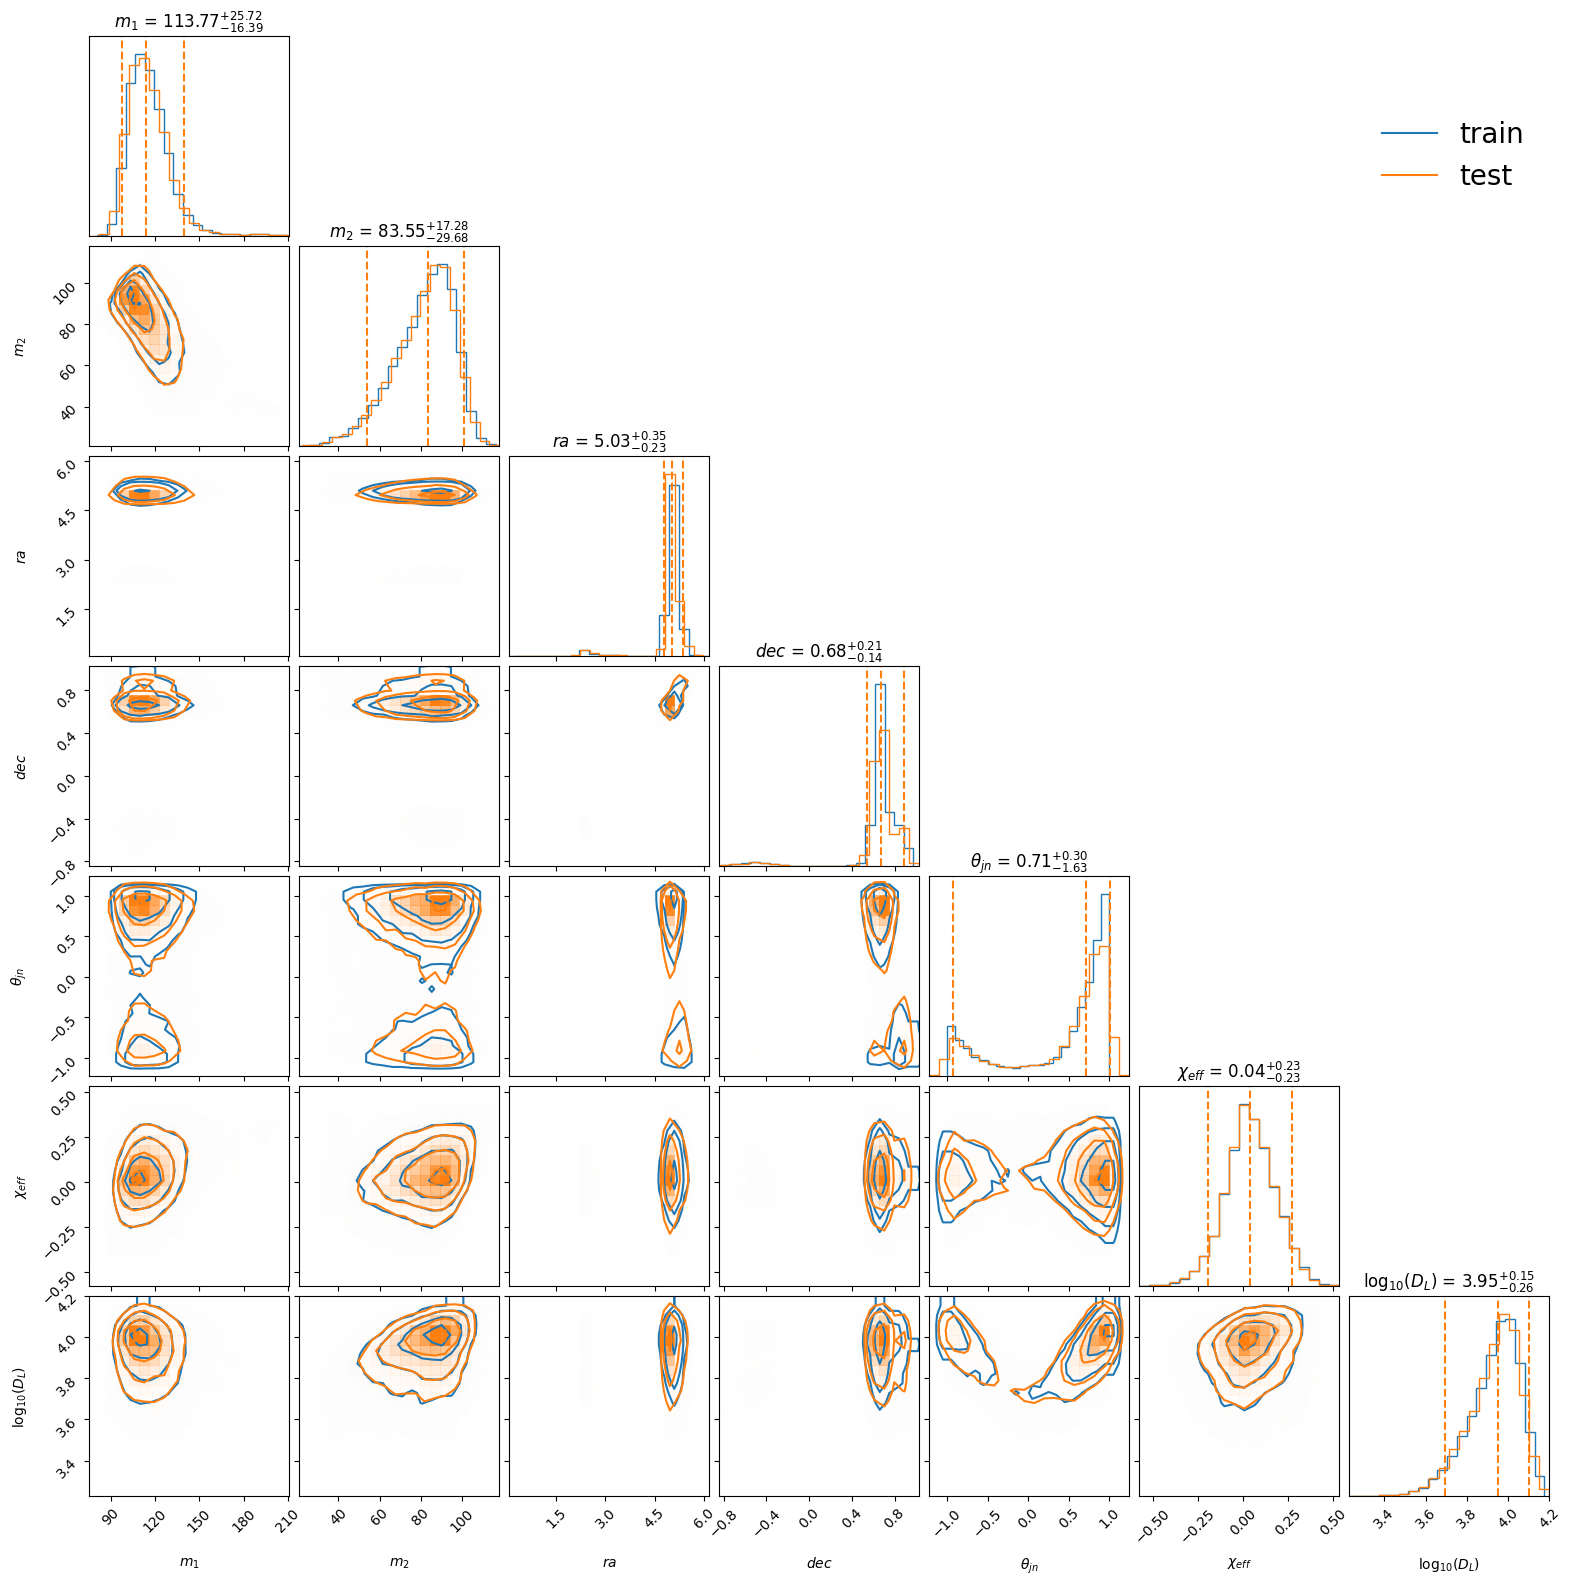

In [81]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_L)$",
]

# to see well, convert to log scale for some parameters
data1_plot = data1.copy()
data1_plot[:,6] = np.log10(data1_plot[:,6])
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])

fig = corner.corner(data1_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 7), loc="upper right"
)
plt.gcf()
plt.show()

* Good enough

In [82]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_posterior_data1.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_posterior_data1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)

### Dataset 2

* $P(m_{1,2}, m_{2,2},\alpha_2, \delta_2, \iota_2, \chi_{eff,2}, d_{L,2}|T_2, d_2)$

In [84]:
data2 = np.array([l1_ps_2['m1'], l1_ps_2['m2'], l1_ps_2['ra'], l1_ps_2['dec'], l1_ps_2['theta_jn'], l1_ps_2['chi_eff'], l1_ps_2['distance']]).T

data_dict = dict(
    mass_1 = data2[:,0],
    mass_2 = data2[:,1],
    ra = data2[:,2],
    sindec = np.cos(np.pi/2. - data2[:,3]),
    costheta_jn = np.cos(data2[:,4]),
    chi_eff = data2[:,5],
    dl = data2[:,6],
)

save_min_max(data_dict, 'ler_data/min_max_posterior_data2.json')

train_data_ = np.array([data_dict['mass_1'], data_dict['mass_2'], data_dict['ra'], data_dict['sindec'], data_dict['costheta_jn'], data_dict['chi_eff'], data_dict['dl']]).T
# m1_min = float(int(min(train_data_[:,0])))
# m1_max = float(int(max(train_data_[:,0])))+1
# m2_min = float(int(min(train_data_[:,1])))
# m2_max = float(int(max(train_data_[:,1])))+1

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)

In [85]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [86]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])
# unscale Dl
new_samples[:,6] = 10**new_samples[:,6]

print(np.shape(new_samples))
print(np.shape(data2))

(40000, 7)
(21071, 7)


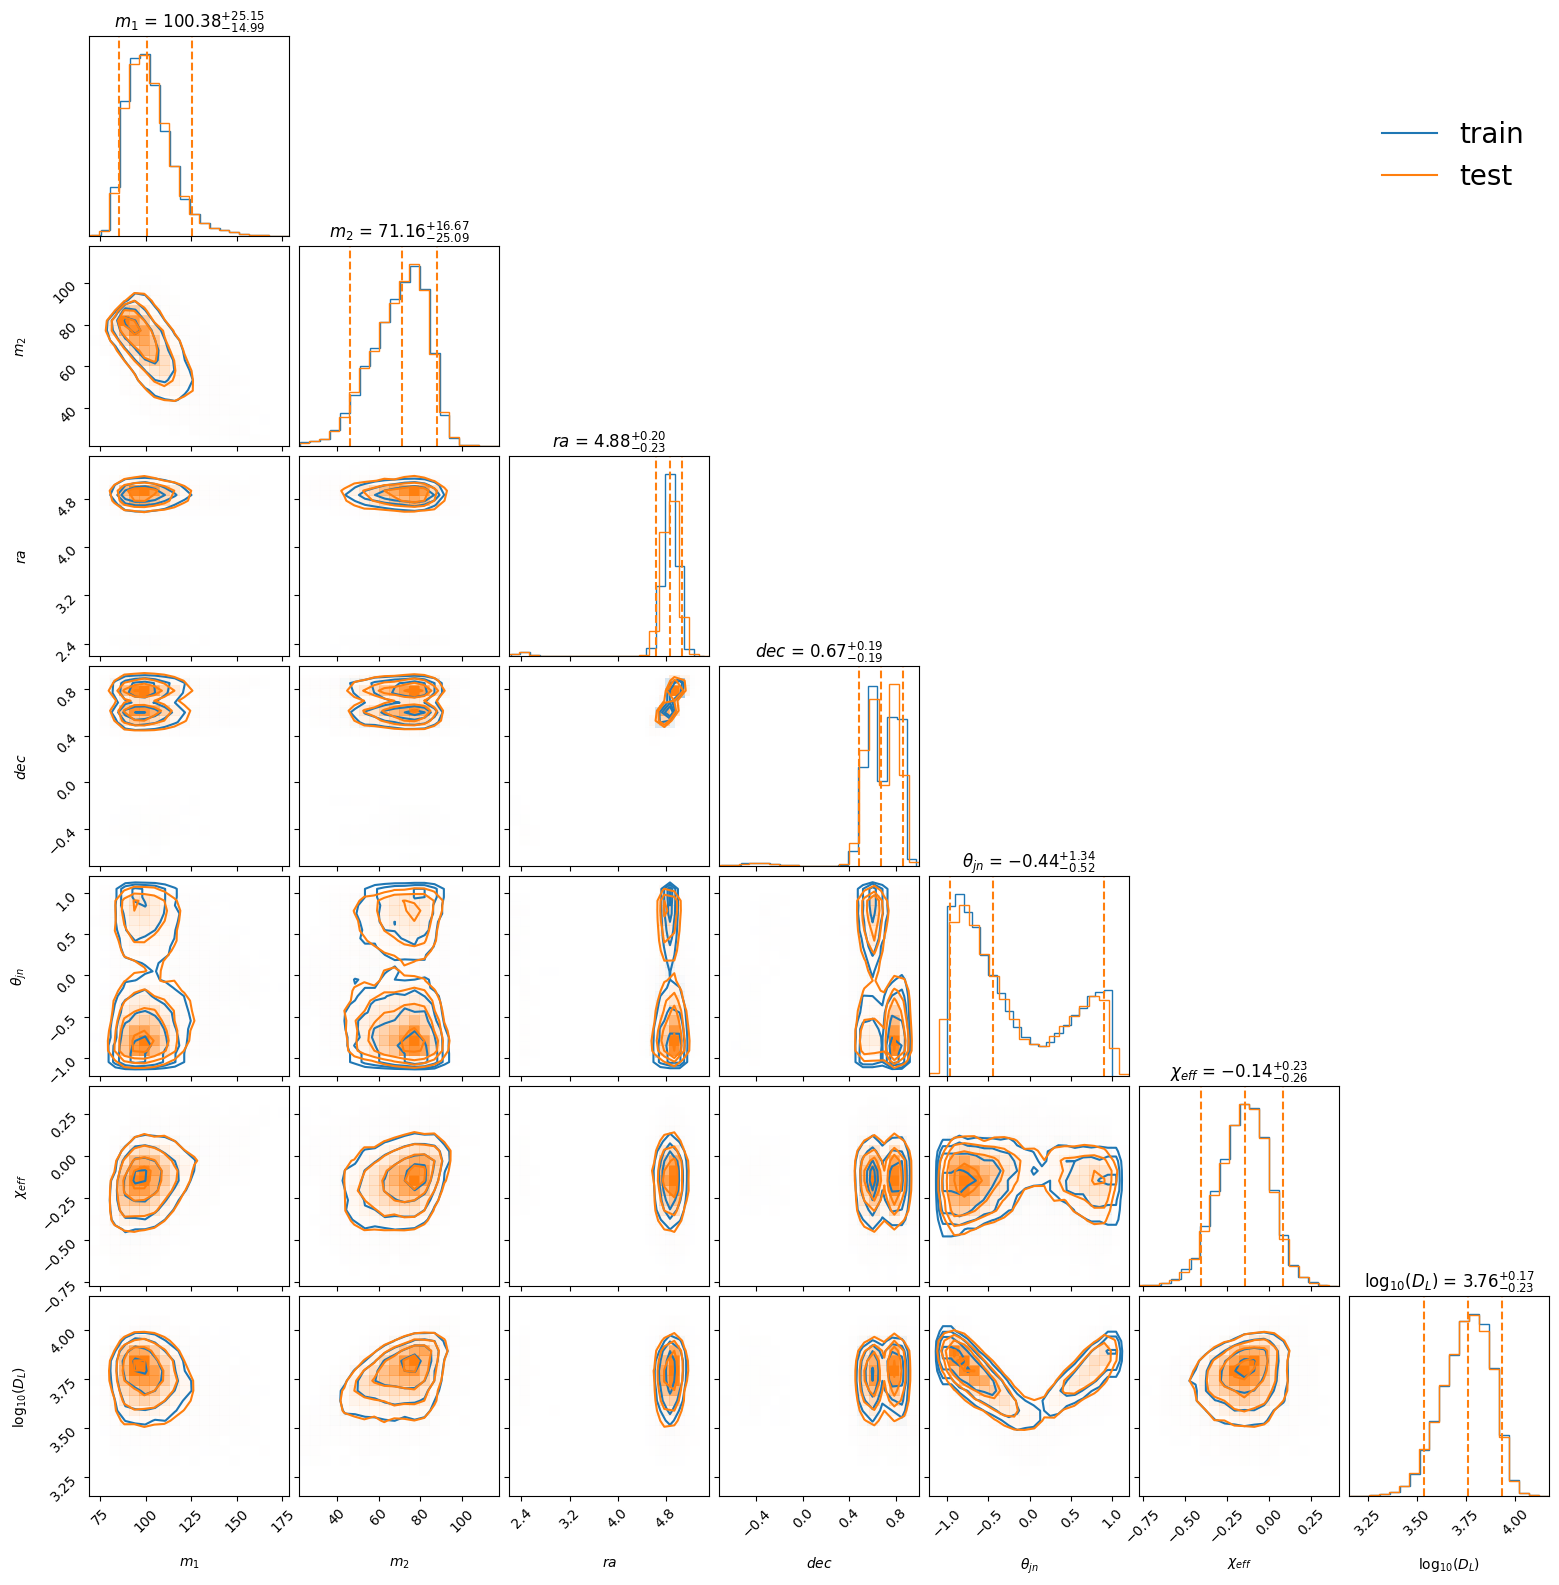

In [88]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_L)$",
]

# to see well, convert to log scale for some parameters
data2_plot = train_data_.copy()
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])

fig = corner.corner(data2_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 7), loc="upper right"
)
plt.gcf()
plt.show()

In [89]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_posterior_data2.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_posterior_data2.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)

### Combine Dataset

In [90]:
np.shape(l1_ps_1), np.shape(l1_ps_2)

((20197, 87), (21071, 87))

In [92]:
params_comb = ['m1', 'm2', 'ra', 'dec', 'theta_jn', 'chi_eff', 'distance']
l1_ps_comb_1 = l1_ps_1[params_comb]
l1_ps_comb_2 = l1_ps_2[params_comb]

m11 = l1_ps_comb_1['m1'].values[:10000]
m12 = l1_ps_comb_2['m1'].values[:10000]
m1 = np.concatenate((m11, m12))
m21 = l1_ps_comb_1['m2'].values[:10000]
m22 = l1_ps_comb_2['m2'].values[:10000]
m2 = np.concatenate((m21, m22))
ra1 = l1_ps_comb_1['ra'].values[:10000]
ra2 = l1_ps_comb_2['ra'].values[:10000]
ra = np.concatenate((ra1, ra2))
sindec1 = np.cos(np.pi/2. - l1_ps_comb_1['dec'].values[:10000])
sindec2 = np.cos(np.pi/2. - l1_ps_comb_2['dec'].values[:10000])
sindec = np.concatenate((sindec1, sindec2))
costheta_jn1 = np.cos(l1_ps_comb_1['theta_jn'].values[:10000])
costheta_jn2 = np.cos(l1_ps_comb_2['theta_jn'].values[:10000])
costheta_jn = np.concatenate((costheta_jn1, costheta_jn2))
chi_eff1 = l1_ps_comb_1['chi_eff'].values[:10000]
chi_eff2 = l1_ps_comb_2['chi_eff'].values[:10000]
chi_eff = np.concatenate((chi_eff1, chi_eff2))
dl_1 = l1_ps_comb_1['distance'].values[:20000]
dl_2 = l1_ps_comb_2['distance'].values[:20000]

data = np.array([m1, m2, ra, sindec, costheta_jn, chi_eff, dl_1, dl_2]).T
data = data[np.random.choice(data.shape[0], 20000, replace=False), :]
np.shape(data)

(20000, 8)

In [93]:
train_data_ = data.copy()
# m1_min = float(int(min(train_data_[:,0])))
# m1_max = float(int(max(train_data_[:,0])))+1
# m2_min = float(int(min(train_data_[:,1])))
# m2_max = float(int(max(train_data_[:,1])))+1

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

# # scale ra
# train_data_[:,2] = uniform_to_gaussian(train_data_[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)

# # scale dec
# train_data_[:,3] = cosine_to_gaussian(train_data_[:,3])

# # scale theta_jn
# train_data_[:,4] = sine_to_gaussian(train_data_[:,4])

# scale Dl_1
train_data_[:,6] = np.log10(train_data_[:,6]) # convert to log10(Mpc)

# scale Dl_2
train_data_[:,7] = np.log10(train_data_[:,7]) # convert to log10(Mpc)

In [94]:
# min max values for scaling
data_dict = dict(
    mass_1 = data[:,0],
    mass_2 = data[:,1],
    ra = data[:,2],
    sindec = data[:,3],
    costheta_jn = data[:,4],
    chi_eff = data[:,5],
    dl_1 = data[:,6],
    dl_2 = data[:,7],
)

save_min_max(data_dict, 'ler_data/min_max_posterior_comb.json')

In [95]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [96]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# # unscale m2
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)
# # unscale ra
# new_samples[:,2] = gaussian_to_uniform(new_samples[:,2], mu=0, sigma=1, upper_bound=6.29, lower_bound=0)
# # unscale dec
# new_samples[:,3] = gaussian_to_cosine(new_samples[:,3])
# # unscale theta_jn
# new_samples[:,4] = gaussian_to_sine(new_samples[:,4])

# unscale Dl_1
new_samples[:,6] = 10**new_samples[:,6]
# unscale Dl_2
new_samples[:,7] = 10**new_samples[:,7]

print(np.shape(new_samples))
print(np.shape(data))

(40000, 8)
(20000, 8)


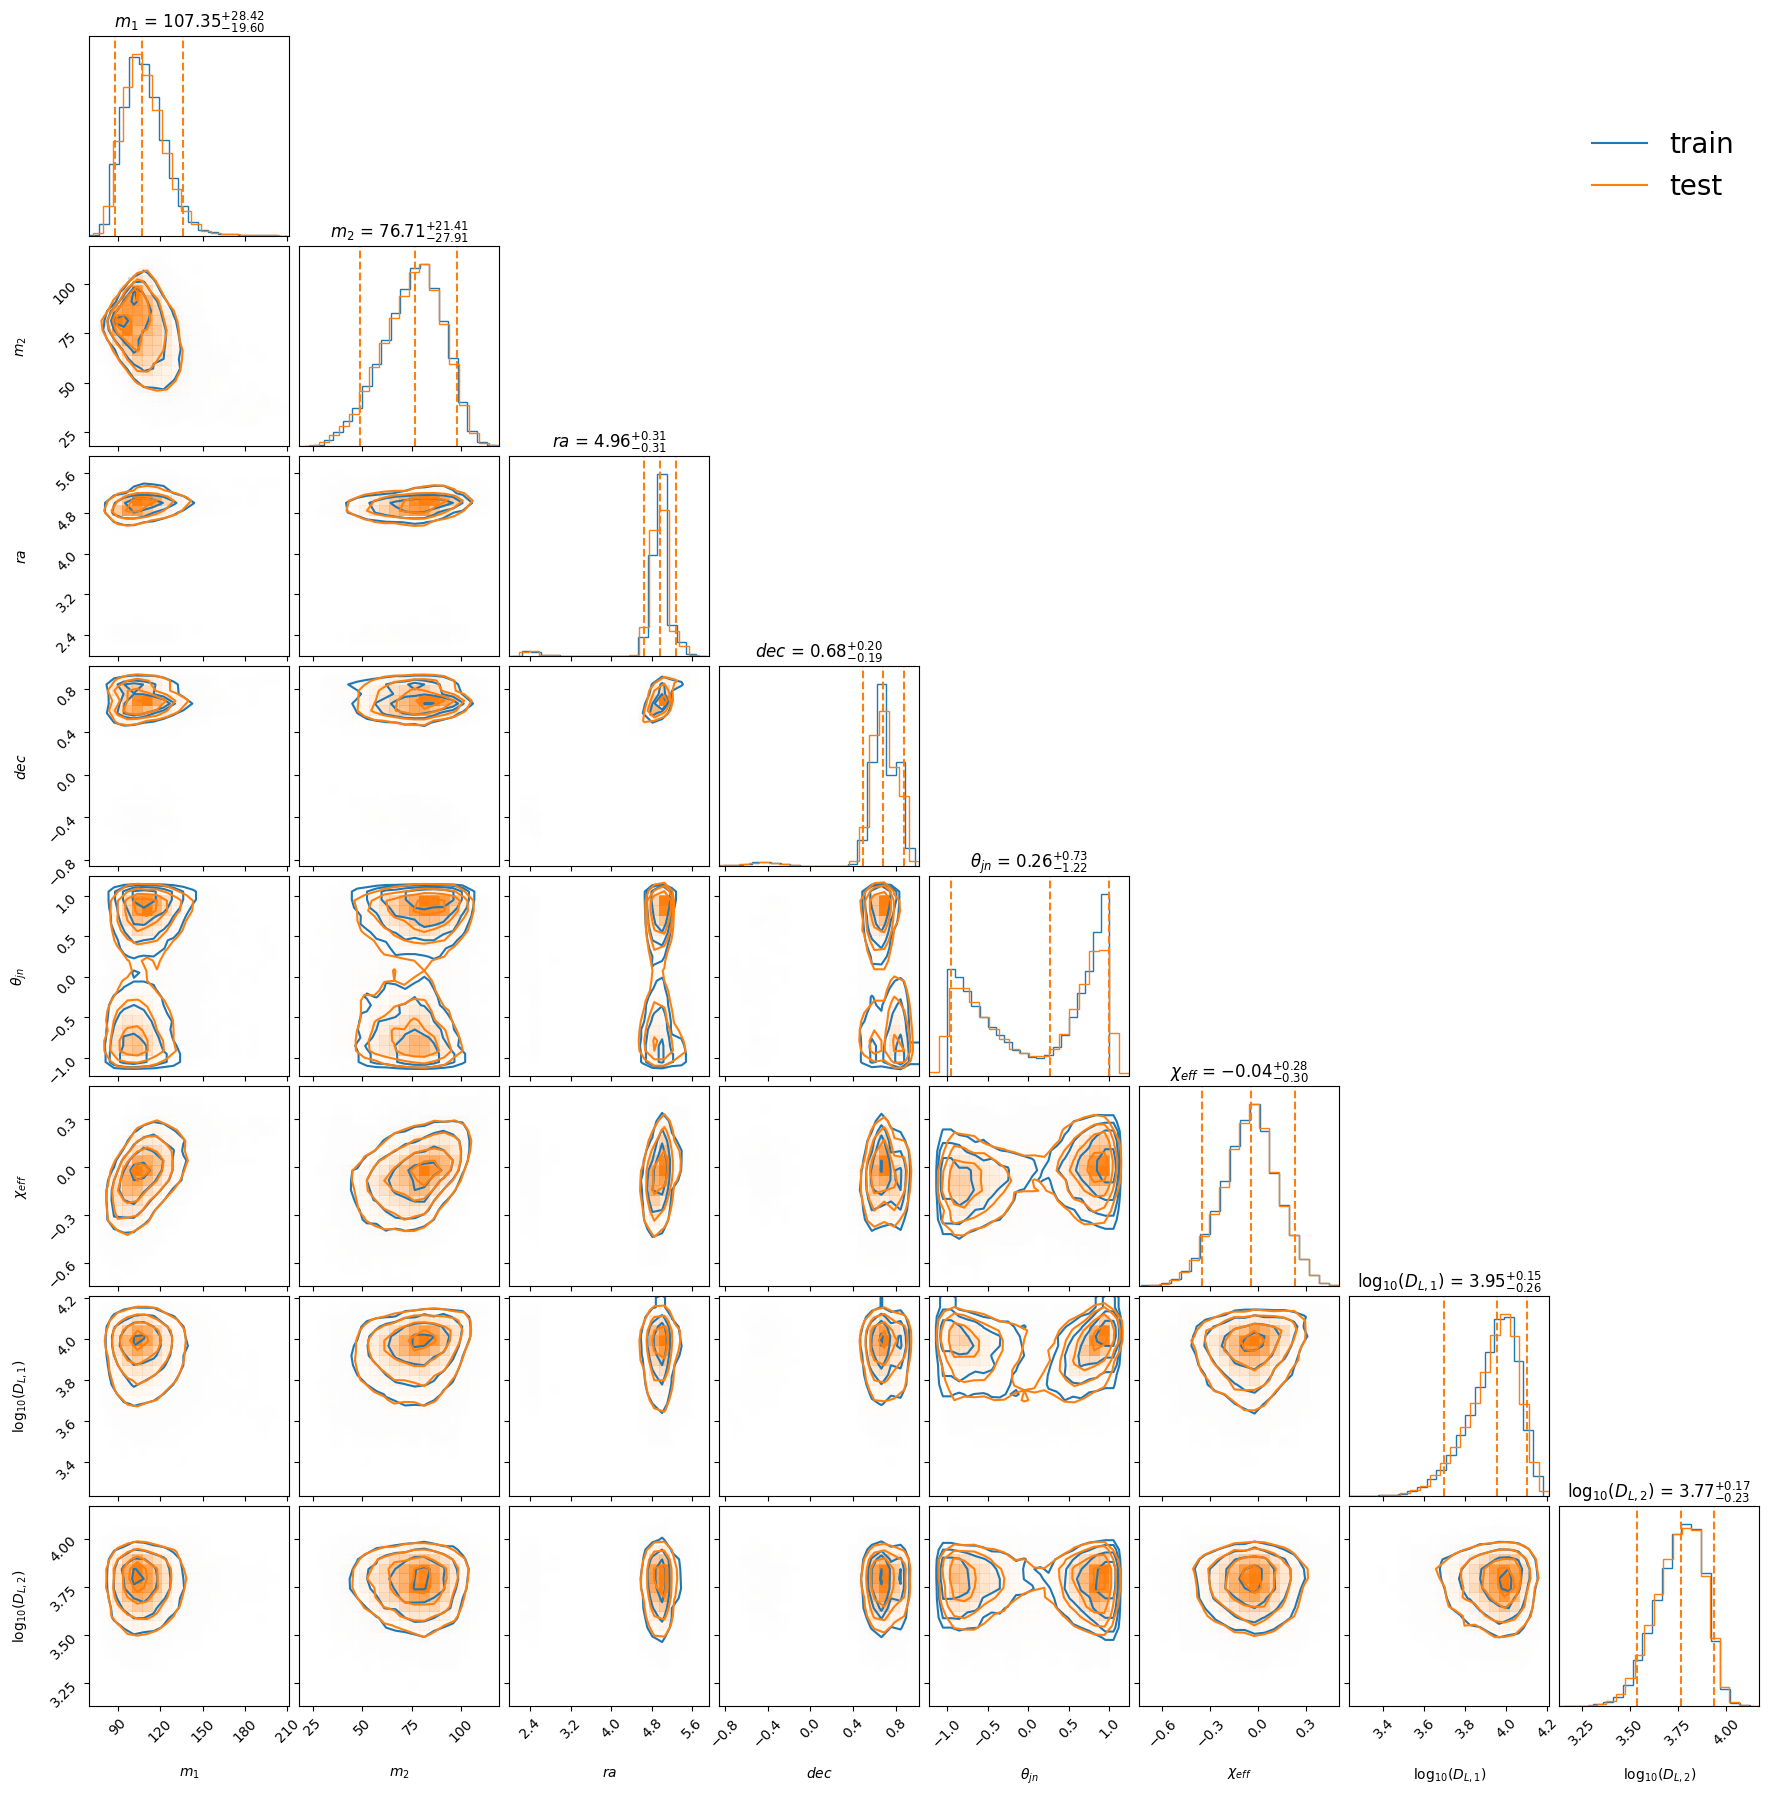

In [97]:
# plot the corner plot
labels = [
    r"$m_1$",
    r"$m_2$",
    r"$ra$",
    r"$dec$",
    r"$\theta_{jn}$",
    r"$\chi_{eff}$",
    r"log$_{10}(D_{L,1})$",
    r"log$_{10}(D_{L,2})$",
]

# to see well, convert to log scale for some parameters
data_plot = data.copy()
data_plot[:,6] = np.log10(data_plot[:,6])
data_plot[:,7] = np.log10(data_plot[:,7])
new_samples_plot = new_samples.copy()
new_samples_plot[:,6] = np.log10(new_samples_plot[:,6])
new_samples_plot[:,7] = np.log10(new_samples_plot[:,7])

fig = corner.corner(data_plot,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples_plot,fig=fig,color='C1',density=True, labels=labels, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 8), loc="upper right"
)
plt.gcf()
plt.show()

In [98]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_posterior_comb.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_posterior_comb.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)

## Priors used for the parameter estimation 

* we will use bilby's default prior for the parameter estimation of BBH

In [99]:
import bilby

# sample m1, m2, ra, dec, cos(theta_jn), mc, chi_eff, distance
# sample from the bilby prior
prior = bilby.gw.prior.BBHPriorDict()

01:07 bilby INFO    : No prior given, using default BBH priors in /Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [100]:
size = 40000
mc = prior['chirp_mass'].sample(size)
q = prior['mass_ratio'].sample(size)
m1 = mc * (1 + q)**(1/5) * q**(3/5)
m2 = m1 * q
ra = prior['ra'].sample(size)
sindec = np.cos(np.pi/2. - prior['dec'].sample(size))
costheta_jn = np.cos(prior['theta_jn'].sample(size))
cos_i = np.cos(theta_jn)
a_1 = prior['a_1'].sample(size) 
a_2 = prior['a_2'].sample(size)
tilt_1 = prior['tilt_1'].sample(size)
tilt_2 = prior['tilt_2'].sample(size)
chi_eff = (a_1*np.cos(tilt_1) + a_2*np.cos(tilt_2))/(m1 + m2)
dl = prior['luminosity_distance'].sample(size)

* as you can see, bilby priors are not correlated, except for m1 and m2 and chi_eff

In [101]:
# params = ["m1","m2","ra","dec","costheta_jn","mc","chi_eff","distance"]
data_ = np.array([m1, m2, chi_eff]).T
# randomize the data
data = data_[np.random.choice(data_.shape[0], 40000, replace=False), :]
np.shape(data)

(40000, 3)

In [102]:
train_data_ = data.copy()
# m1_min = float(int(min(train_data_[:,0])))
# m1_max = float(int(max(train_data_[:,0])))+1
# m2_min = float(int(min(train_data_[:,1])))
# m2_max = float(int(max(train_data_[:,1])))+1

# # scale m1
# train_data_[:,0] = scale_to_range(train_data_[:,0], min_data=m1_min, max_data=m1_max)
# train_data_[:,0] = sine_to_gaussian(train_data_[:,0])

# # scale m2
# train_data_[:,1] = scale_to_range(train_data_[:,1], min_data=m2_min, max_data=m2_max)
# train_data_[:,1] = sine_to_gaussian(train_data_[:,1])

In [103]:
# min max values for scaling
data_dict = dict(
    mass_1 = data[:,0],
    mass_2 = data[:,1],
    chi_eff = data[:,2],
)

save_min_max(data_dict, 'ler_data/min_max_prior_pe_m1m2chieff.json')

In [104]:
from sklearn.preprocessing import StandardScaler
# Choose a scaler:
scaler = StandardScaler()  # or MinMaxScaler(), RobustScaler()

# Scale the data
scaled_data = scaler.fit_transform(train_data_)

# Fit the model
KDE = gaussian_kde(scaled_data.T)
KDE.set_bandwidth(bw_method=KDE.factor / 4.)

In [105]:
# sample new points from the model
new_samples = KDE.resample(size=40000).T

# unscale the data
new_samples = scaler.inverse_transform(new_samples)

# # unscale m1, m2
# new_samples[:,0] = gaussian_to_sine(new_samples[:,0])
# new_samples[:,1] = gaussian_to_sine(new_samples[:,1])
# # unscale to the original range
# new_samples[:,0] = unscale_to_range(new_samples[:,0], min_data=m1_min, max_data=m1_max)
# new_samples[:,1] = unscale_to_range(new_samples[:,1], min_data=m2_min, max_data=m2_max)

In [15]:
# plt.figure(figsize=[4,4])
# plt.hist(new_samples[:,0], bins=100, density=True, alpha=0.5, histtype='step', color='r')
# plt.hist(new_samples[:,1], bins=100, density=True, alpha=0.5, histtype='step', color='b')
# plt.show()

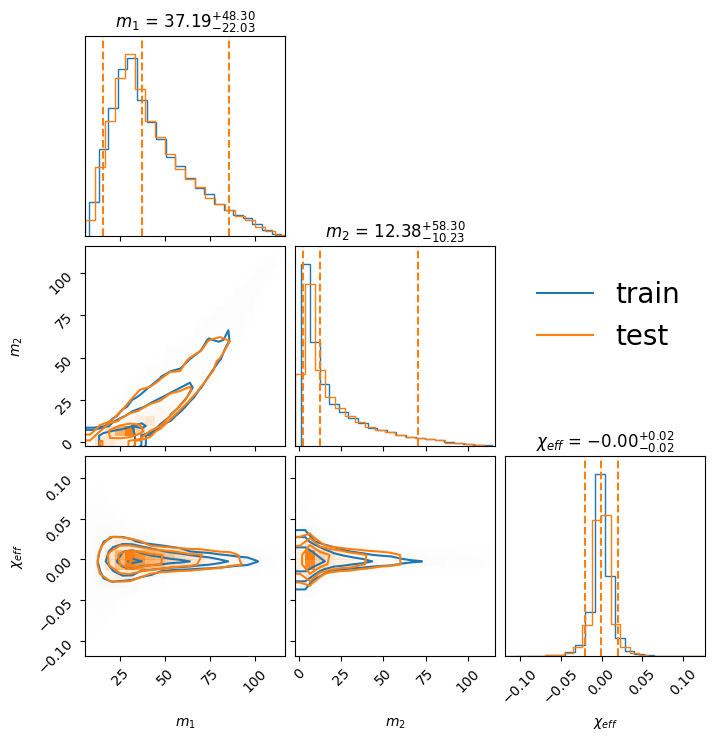

In [106]:
import corner
import matplotlib.lines as mlines
labels2 = [
    r"$m_1$",
    r"$m_2$",
    r"$\chi_{eff}$",
]
# normalize
# dont show scatter points
fig = corner.corner(data,color = 'C0', density = True, plot_datapoints=False, label='train', hist_kwargs={'density':True})
corner.corner(new_samples,fig=fig,color='C1',density=True, labels=labels2, show_titles=True, plot_datapoints=False, quantiles=[0.05, 0.5, 0.95], hist_kwargs={'density':True})

colors = ['C0', 'C1']
sample_labels = ['train', 'test']
plt.legend(
    handles=[
        mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
        for i in range(2)
    ],
    fontsize=20, frameon=False,
    bbox_to_anchor=(1, 2), loc="upper right"
)
plt.gcf()
plt.show()

In [107]:
# let's save both the model and scaler
import pickle
KDE = gaussian_kde(scaled_data.T)
with open('ler_data/gaussian_kde_prior_pe_m1m2chieff.pkl', 'wb') as f:
    pickle.dump(KDE, f)

with open('ler_data/scaler_prior_pe_m1m2chieff.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# # load the model and scaler
# with open('ler_data/gaussian_kde_astro_unlensed1.pkl', 'rb') as f:
#     dpgmm = pickle.load(f)

# with open('ler_data/scaler_astro_unlensed1.pkl', 'rb') as f:
#     scaler = pickle.load(f)